# FER Baseline Finetune Model

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import *

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/fer.csv')

## EDA

In [5]:
df.head()

,emotion,pixels
0,1,204 206 200 104 71 77 112 170 193 204 218 223 ...
1,1,19 21 27 28 33 29 41 37 24 31 42 45 48 62 63 7...
2,1,223 245 233 243 243 243 244 244 248 245 218 21...
3,1,119 30 120 166 119 101 108 91 51 58 68 82 100 ...
4,1,76 93 103 96 99 103 103 120 134 138 149 150 14...


In [6]:
df.shape

(17978, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17978 entries, 0 to 17977
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  17978 non-null  int64 
 1   pixels   17978 non-null  object
dtypes: int64(1), object(1)
memory usage: 281.0+ KB


In [8]:
df.emotion.value_counts()

1    8989
0    8989
Name: emotion, dtype: int64

## Pre-processing

In [9]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [10]:
img_array.shape

(17978, 48, 48, 1)

In [11]:
img_labels = df.emotion.values

In [12]:
img_labels.shape

(17978,)

## Splitting the data into training and testing set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(img_array, 
                                                    img_labels,
                                                    test_size=0.1, 
                                                    shuffle=True,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1, 
                                                  random_state=42)

In [14]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("\n")
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))
print("\n")
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (14562, 48, 48, 1)
y_train shape: (14562,)


X_val shape: (1618, 48, 48, 1)
y val shape: (1618,)


X_test shape: (1798, 48, 48, 1)
y_test shape: (1798,)


In [15]:
print(np.round(((X_train.shape[0]) / (img_array.shape[0]))*100), "% of Train set")
print(np.round(((X_val.shape[0]) / (img_array.shape[0]))*100), "% of Validation set")
print(np.round(((X_test.shape[0]) / (img_array.shape[0]))*100), "% of Test set")

81.0 % of Train set
9.0 % of Validation set
10.0 % of Test set


## Image Properties

In [16]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

In [17]:
print("The following are the image properties :")
print("   Width =", img_width)
print("   Height =", img_height)
print("   Depth =", img_depth)

The following are the image properties :
   Width = 48
   Height = 48
   Depth = 1



## Normalization

In [18]:
X_train = X_train / 255.

X_val = X_val / 255.

X_test = X_test / 255.

## Model

In [19]:
def model():

    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=32,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'))
    
    net.add(BatchNormalization(name='batchnorm_1'))
    
    net.add(
        Conv2D(
            filters=32,
            kernel_size=(5,5),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'))
    
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'))

    net.add(BatchNormalization(name='batchnorm_3'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'))
    
    net.add(BatchNormalization(name='batchnorm_4'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'))
    
    net.add(BatchNormalization(name='batchnorm_5'))
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'))
    
    net.add(BatchNormalization(name='batchnorm_6'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'))
    
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'))
    
    net.add(BatchNormalization(name='batchnorm_8'))
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_4'))
    net.add(Dropout(0.5, name='dropout_4'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            512,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_1'))
    
    net.add(BatchNormalization(name='batchnorm_9'))
    net.add(Dropout(0.6, name='dropout_5'))
    
    net.add(
        Dense(
            128,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_2'))
    
    net.add(BatchNormalization(name='batchnorm_10'))
    net.add(Dropout(0.6, name='dropout_6'))
    

    net.add(
        Dense(
            1,
            activation='sigmoid',
            name='out_layer'))
    
    net.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    
    net.summary()
    
    return net

## Callbacks

In [20]:
checkpoint = ModelCheckpoint(filepath='fernet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0.00005, 
                          patience=11, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=7, 
                              verbose=1, 
                              min_lr=1e-7)

callbacks = [checkpoint, early_stopping, reduce_lr]

## Model Summary

In [21]:
fernet = model()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        832       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 32)       128       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 32)       128       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0      

In [22]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 37.6 MB/s eta 0:00:00


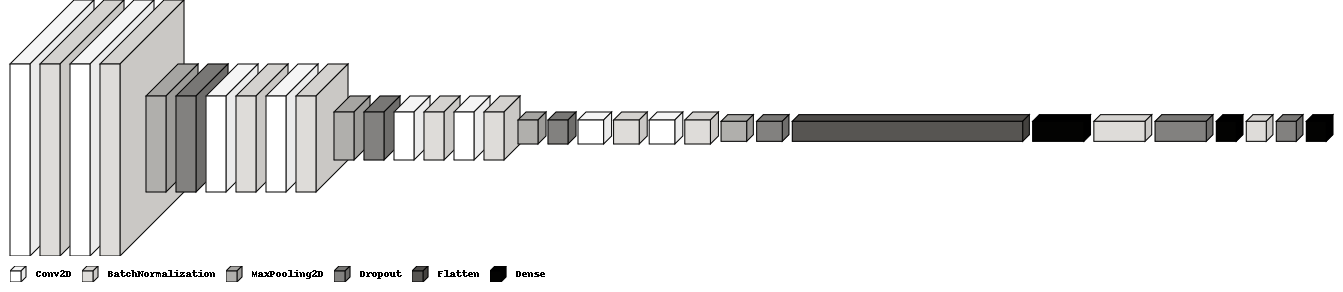

In [23]:
import visualkeras
from tensorflow.keras import layers
from collections import defaultdict

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#ffffff'
color_map[layers.BatchNormalization]['fill'] = '#dedcd9'
color_map[layers.MaxPooling2D]['fill'] = '#b0afac'
color_map[layers.Dropout]['fill'] = '#82817f'
color_map[layers.Dense]['fill'] = '#030302'
color_map[layers.Flatten]['fill'] = '#575552'

visualkeras.layered_view(fernet, legend=True, color_map=color_map, draw_volume=True, draw_funnel=False)

## Model Training

In [24]:
batch_size = 32
epochs = 50
steps_per_epoch = len(X_train) / batch_size
validation_steps = len(X_val) / batch_size

In [25]:
history = fernet.fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     steps_per_epoch=steps_per_epoch,
                     epochs=epochs,
                     callbacks=callbacks,
                     validation_steps=validation_steps)

Epoch 1/50
456/455 [==============================] - ETA: 0s - loss: 0.8557 - accuracy: 0.5478
Epoch 1: val_loss improved from inf to 0.63817, saving model to fernet.h5
455/455 [==============================] - 30s 22ms/step - loss: 0.8557 - accuracy: 0.5478 - val_loss: 0.6382 - val_accuracy: 0.6384 - lr: 0.0010
Epoch 2/50
454/455 [============================>.] - ETA: 0s - loss: 0.6493 - accuracy: 0.6381
Epoch 2: val_loss improved from 0.63817 to 0.58350, saving model to fernet.h5
455/455 [==============================] - 9s 19ms/step - loss: 0.6493 - accuracy: 0.6382 - val_loss: 0.5835 - val_accuracy: 0.6941 - lr: 0.0010
Epoch 3/50
454/455 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.7137
Epoch 3: val_loss improved from 0.58350 to 0.47610, saving model to fernet.h5
455/455 [==============================] - 9s 19ms/step - loss: 0.5603 - accuracy: 0.7136 - val_loss: 0.4761 - val_accuracy: 0.7645 - lr: 0.0010
Epoch 4/50
455/455 [==========================

## Result Plots

In [26]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "train_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")   
    plt.legend()
    
    plt.tight_layout()

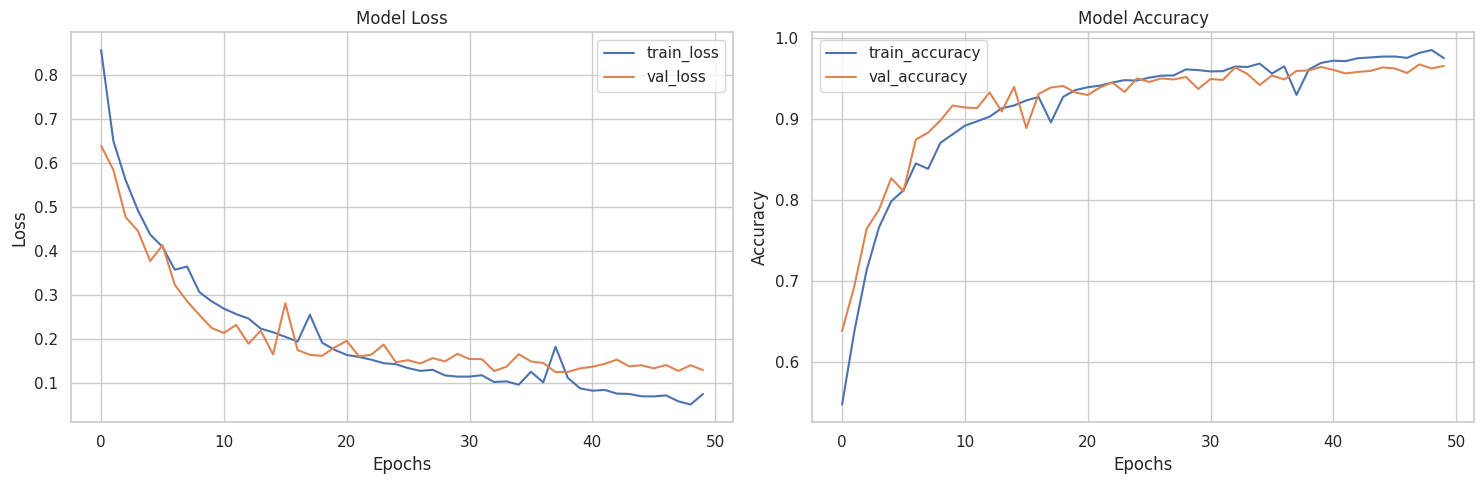

In [27]:
plot_curves(history)

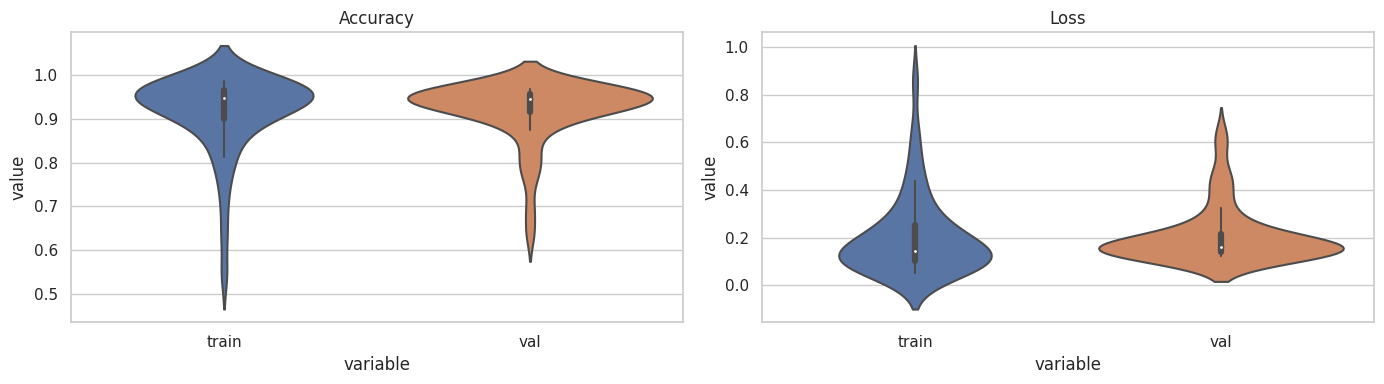

In [28]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'val': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.show()

### Model Evaluation

In [29]:
train_loss, train_accuracy = fernet.evaluate(X_train, y_train)
print("Train loss = {:.2f}".format(train_loss))
print("Train accuracy = {:.2f}%".format(train_accuracy*100))

456/456 [==============================] - 3s 6ms/step - loss: 0.0058 - accuracy: 0.9990
Train loss = 0.01
Train accuracy = 99.90%


In [30]:
val_loss, val_accuracy = fernet.evaluate(X_val, y_val)
print("Validation loss = {:.2f}".format(val_loss))
print("Validation accuracy = {:.2f}%".format(val_accuracy*100))

51/51 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.9654
Validation loss = 0.13
Validation accuracy = 96.54%


In [31]:
val_pred = fernet.predict(X_val)
y_val_pred = np.where(val_pred > 0.5, 1, 0)

51/51 [==============================] - 0s 5ms/step


Confusion Matrix


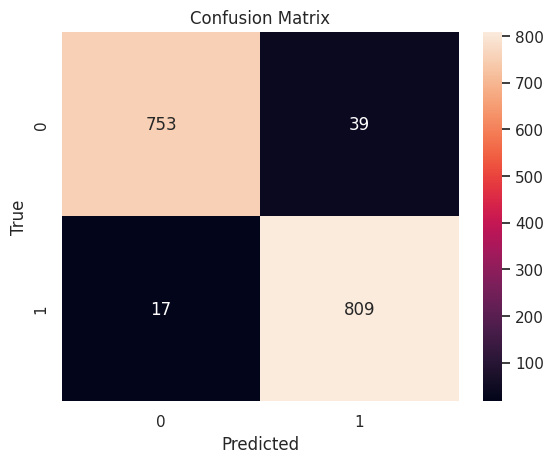

In [32]:
print('Confusion Matrix')

cm = tf.math.confusion_matrix(y_val, y_val_pred, num_classes=2, dtype=tf.dtypes.int32)

sns.heatmap(cm, annot=True, fmt="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

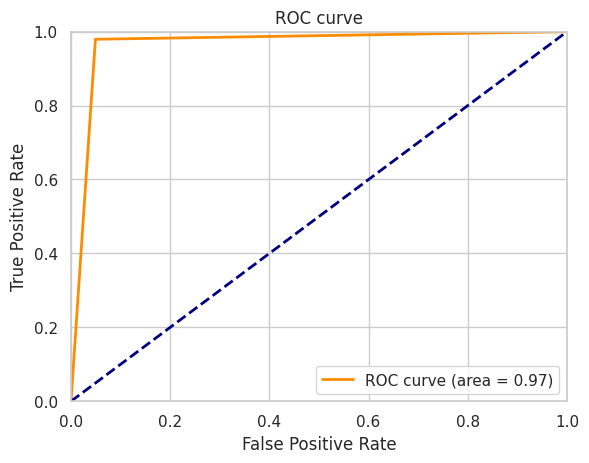

In [33]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### New data for Predictions

In [34]:
pred = fernet.predict(X_test)
y_pred = np.where(pred > 0.5, 1, 0)

57/57 [==============================] - 0s 9ms/step


In [35]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       901
           1       0.94      0.98      0.96       897

    accuracy                           0.96      1798
   macro avg       0.96      0.96      0.96      1798
weighted avg       0.96      0.96      0.96      1798



In [36]:
test_loss, test_accuracy = fernet.evaluate(X_test, y_test)
print("Test loss = {:.2f}".format(test_loss))
print("Test accuracy = {:.2f}%".format(test_accuracy*100))

57/57 [==============================] - 0s 6ms/step - loss: 0.1462 - accuracy: 0.9594
Test loss = 0.15
Test accuracy = 95.94%


In [37]:
acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f} \nPrecision: {prec:.2f} \nRecall: {rec:.2f}")

Accuracy: 0.96 
Precision: 0.94 
Recall: 0.98


In [38]:
Emotion_Classes = {0 : 'happy', 1 : 'sad'}

1/1 [==============================] - 0s 21ms/step


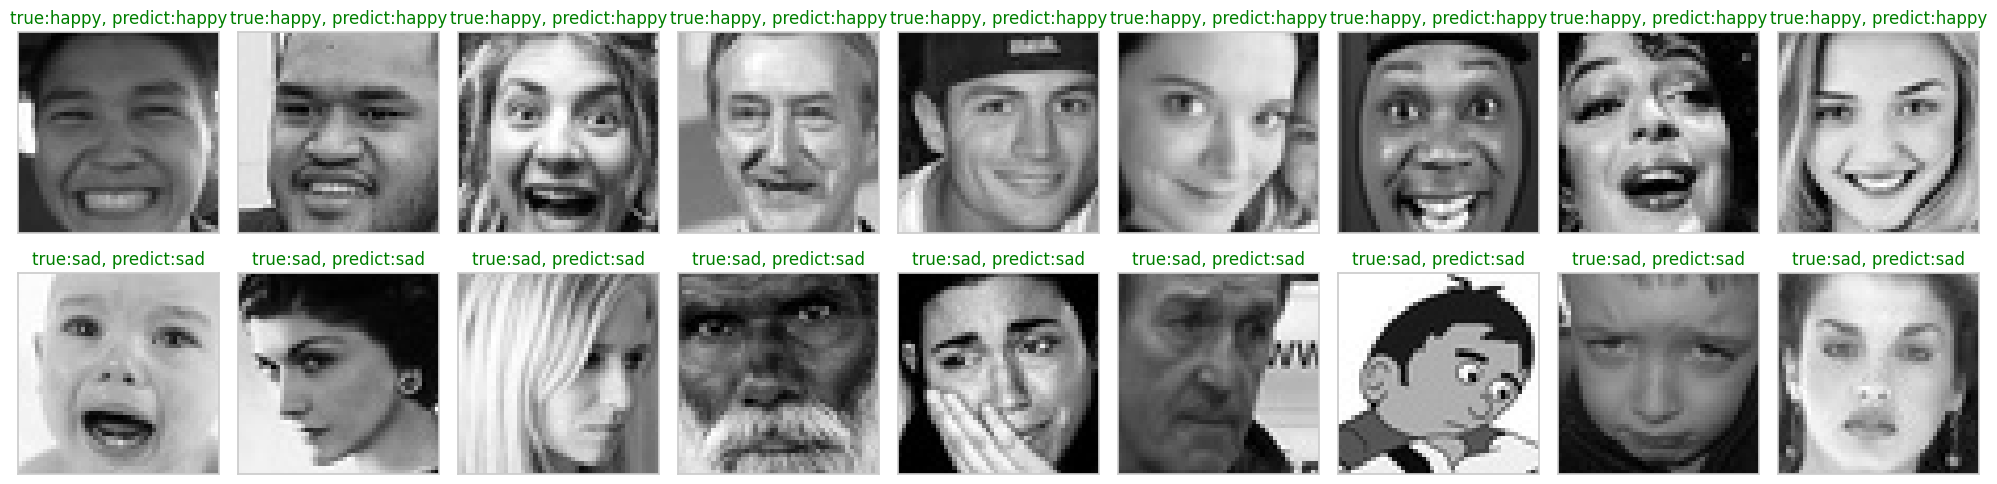

In [39]:
np.random.seed(2)
random_happy_imgs = np.random.choice(np.where(y_test[:]==0)[0], size=9)
random_sad_imgs = np.random.choice(np.where(y_test[:]==1)[0], size=9)

fig = plt.figure(1, (20, 5))

for i, (happyidx, sadidx) in enumerate(zip(random_happy_imgs, random_sad_imgs)):

        ax = plt.subplot(2, 9, i+1)
        hap_sample_img = X_test[happyidx,:,:,0]
        hap_img_resized = hap_sample_img.reshape(1,48,48,1)
        hap_pred = fernet.predict(hap_img_resized)
        y_pred_hap = np.where(hap_pred > 0.5, 1, 0)
        
        if (y_pred_hap[0]) == (y_test[happyidx]):
            color_hap = "green"
        else:
            color_hap = "red"

        hap_img = hap_img_resized.reshape(48,48)
        ax.imshow(hap_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:happy, predict:{Emotion_Classes[y_pred_hap[0][0]]}", color=color_hap)

        ax = plt.subplot(2, 9, i+10)
        sad_sample_img = X_test[sadidx,:,:,0]
        sad_img_resized = sad_sample_img.reshape(1,48,48,1)
        sad_pred = fernet.predict(sad_img_resized)
        y_pred_sad = np.where(sad_pred > 0.5, 1, 0)

        if (y_pred_sad[0]) == (y_test[sadidx]):
            color_sad = "green"
        else:
            color_sad = "red"

        sad_img = sad_img_resized.reshape(48,48)
        ax.imshow(sad_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, predict:{Emotion_Classes[y_pred_sad[0][0]]}", color=color_sad)

        plt.tight_layout()

`Baseline model`